<h1><big><center>Object recognition and computer vision 2021/2022</center></big></h1>

<h2><big><center> Assignment 3: Image Classification</center></big></h2>

This notebook aims at describing the full pipeline used to perform species classification on a subset of the `Caltech-UCSD Birds-200-2011`. This notebook was run on Kaggle to take advantage of the free GPU.

**STUDENT**:  Matias ETCHEVERRY

**EMAIL**:  matias.etcheverry9@gmail.com

## Loading packages

This notebook uses `neptune.ai`. This plateform is very usefull to see metrics in live, kill models which are over/underfitting and save artefacts. If you have an account, you can simply replace the `neptune_key` variable. Otherwise, you can simply delete the code related to `neptune` (mainly the loggers)

I noticed that the Kaggle environment doesn't have the last version of `torchvision` which is used to load pretrained model. The `0.13` version introduces a lot of pretrained models on different dataset, with different trainings.

In [27]:
!pip install neptune-client torchvision==0.13 --upgrade -q


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 0.12.1 requires torch==1.12.1, but you have torch 1.12.0 which is incompatible.

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [28]:
import sys
from copy import deepcopy
from pathlib import Path
from pprint import pprint
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torchmetrics
import torchvision
import torchvision.models as pretrained_models
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import NeptuneLogger
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
seed = 42
num_workers = 2 if use_cuda else 4
torch.manual_seed(seed)

## Loading the dataset and the dataloaders.

### Creating a custom dataset

The next step is to load the datasets. 

As I initally worked with the broken dataset on Kaggle, I needed to make the `class_to_idx` trick. Indeed, without it, if the training and validation dataset don't have the same number of classers (/folders), the groundtruth labels won't have the same value. Moreover, we create a custom dataset, so that a single input is made of a dict like:

```{python}
single_input = {
    "image": tensor_image,
    "path": path_to_the_image,
    "width": original_width_of_the_image,
    "height: original_height_of_the_image
}
```

In [29]:
path_to_datasets = (
    Path("/kaggle/input/recvis3") if "kaggle_secrets" in sys.modules else Path("")
)
class_to_idx = datasets.ImageFolder(
    path_to_datasets / "bird_dataset/train_images",
).class_to_idx


class FullImageDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.files = [x for x in self.root_dir.glob("**/*") if x.is_file()]
        self.class_to_idx = class_to_idx
        self.idx_to_nb_samples = {
            idx: len([x for x in self.files if class_name in str(x)])
            for class_name, idx in self.class_to_idx.items()
        }

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx: int):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_to_idx.get(img_path.parent.name, -1)
        width = image.width
        height = image.height

        if self.transform is not None:
            image = self.transform(image)

        return {
            "image": image,
            "label": label,
            "path": img_path,
            "width": width,
            "height": height,
        }


def collate_batch(batch):
    images = torch.stack([elem["image"] for elem in batch])
    labels = torch.LongTensor([elem["label"] for elem in batch])
    paths = [elem["path"] for elem in batch]
    widths = [elem["width"] for elem in batch]
    heights = [elem["height"] for elem in batch]
    return {
        "images": images,
        "labels": labels,
        "paths": paths,
        "widths": widths,
        "heights": heights,
    }


### Creating the custom dataloaders

We then create the dataloaders, using the `pytorch-lightning` features. This is particularly usefull when making the predictions on the test set.

In [30]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        path_to_datasets,
        class_to_idx,
        train_transforms,
        val_transforms,
    ):
        super().__init__()
        self.config = config
        self.path_to_datasets = Path(path_to_datasets)
        self.class_to_idx = class_to_idx
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms

    def train_dataloader(self):
        dataset = FullImageDataset(
            self.path_to_datasets / "train_images_cropped",
            transform=self.train_transforms,
            class_to_idx=class_to_idx,
        )
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.config["batch_size"],
            num_workers=self.config["num_workers"],
            collate_fn=collate_batch,
            shuffle=True,
        )

    def val_dataloader(self):
        dataset = FullImageDataset(
            self.path_to_datasets / "val_images_cropped",
            transform=self.val_transforms,
            class_to_idx=class_to_idx,
        )
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.config["batch_size"],
            num_workers=self.config["num_workers"],
            collate_fn=collate_batch,
            shuffle=False,
        )

    def predict_dataloader(self):
        return torch.utils.data.DataLoader(
            FullImageDataset(
                self.path_to_datasets / "test_images_cropped",
                transform=self.val_transforms,
                class_to_idx=class_to_idx,
            ),
            batch_size=self.config["batch_size"],
            shuffle=False,
            num_workers=self.config["num_workers"],
            collate_fn=collate_batch,
        )


## Initialize hyper-parameters

Then we initialize a config dictionnary that will store every parameters of our model. In particular, it will store the batch size, which is needed for the dataloaders. Thus, we initialize the config dictionnary and we will populate it later with more parameters

In [31]:
config = {}
config["batch_size"] = 8
config["device"] = device
config["num_workers"] = num_workers


## Crop all the images

A key step is to crop all the images, so that it is entirely focus on the bird (as there is only one per image !)

### Load the pretrained model

We first load the pretrained model used for bird detection. It outputs a bounding box of each bird in an image (if there is some).

In [ ]:
model = torch.hub.load("facebookresearch/detr", "detr_resnet50", pretrained=True)
model.eval()


In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((800, 800)),
        transforms.ToTensor(),
    ],
)


def rescale_bboxes(out_bbox, width, height):
    """Rescale a bounding box in [0, 1] so that it matches the image `width` and `height`."""
    x_c, y_c, w, h = out_bbox
    h = max(h, w * width / height)
    w = max(w, h * height / width)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    b = b * torch.tensor([width, height, width, height], dtype=torch.float32)
    return b

# index of the bird class in the pretrained model
bird_index = 16


### Crop the images

Then, we iterate over each dataset, crop the images and OVERWRITE the current image with the cropped images

In [ ]:
for dataset_path in ["train_images", "val_images", "test_images"]:
    dataset = FullImageDataset("bird_dataset/train_images", transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_batch,
    )
    with tqdm(dataloader, unit="batch") as vepoch:
        model.eval()
        for batch in vepoch:
            images = batch["images"]
            paths = batch["paths"]
            widths = batch["widths"]
            heights = batch["heights"]

            outputs = model(images)
            for pred_boxes, pred_logits, path, width, height in zip(
                outputs["pred_boxes"], outputs["pred_logits"], paths, widths, heights
            ):
                # keep only the relevant predictions
                probas = pred_logits.softmax(-1)
                keep = probas[:, bird_index] > 0.7

                # image to crop
                im = Image.open(path).convert("RGB")

                # tricky part
                # if there is at least 1 bird detection
                if torch.sum(keep) > 0:
                    # take the detection with the smallest bounding borx
                    largest_box_index = np.argmin(
                        [(box[2] * box[3]).item() for box in pred_boxes[keep]]
                    )
                    # rescale the bounding box
                    bboxes_scaled = rescale_bboxes(
                        pred_boxes[keep][largest_box_index], width, height
                    )
                    # crop the image
                    im = im.crop(bboxes_scaled.tolist())
                else:
                    print(f"Image at {path} not cropped")
                im.save(path)


Some images couldn't be cropped by the model. There a few of them:

* Images with problem on training set:

    * `004.Groove_billed_Ani/Groove_Billed_Ani_0068_1538.jpg`
    * `030.Fish_Crow/Fish_Crow_0024_26064.jpg`
    * `028.Brown_Creeper/Brown_Creeper_0111_24590.jpg`


* Images with problem on validation set:

    * `026.Bronzed_Cowbird/Bronzed_Cowbird_0002_796244.jpg`


* Image with problem on test set:

    * `mistery_category/0247efd7b9d47d036bb4390202a13e69.jpg`
    * `mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg`
    * `mistery_category/15d6c5d42688cbc390e9ba241e93b941.jpg`
    * `mistery_category/0ab685b1515b7d4c76691e8373a65f47.jpg`
    * `mistery_category/4836bedeec2a2617ee33922ebf89995a.jpg`
    * `mistery_category/8367922ad8b74c6047ea82f4d527ce04.jpg`

## Create image transformation pipeline

The next step is to create a pipeline of image transformations. This pipeline is slightly different between the training and the validation datasets as it needs to incorporate some data augmentations.

In the training and validation set, we :

* resize the image so they fit the pretrained model ($384 \times 384$)
* transform the images to tensors
* normalize them

In the training set, we add random transformations:

* the brightness and the saturation are slightly altered
* the image rotated with angle in $[-20°, 20°]$
* the image is flipped vertically and/or horizontally with probability 0.5
* the image is randomly zoomed in
* a part of the image is randomly erased, with proba 0.8

In [32]:
config["width"] = 384

data_transforms = transforms.Compose(
    [
        transforms.Resize(
            (config["width"], config["width"]),
            interpolation=transforms.InterpolationMode.BICUBIC,
        ),
        transforms.CenterCrop(config["width"]),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.1, saturation=0.5),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomAffine(20),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomResizedCrop(384, scale=(0.4, 1.0), ratio=(0.75, 1, 3)),
        transforms.RandomErasing(p=0.8, scale=(0.02, 0.7), ratio=(0.3, 3.3)),
    ]
)

val_data_transforms = transforms.Compose(
    [
        transforms.Resize(
            (config["width"], config["width"]),
            interpolation=transforms.InterpolationMode.BICUBIC,
        ),
        transforms.CenterCrop(config["width"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


## Explore the dataloaders

We may want to know what our data looks like. To do so, we simply iterate on the 3 dataloaders: the training, the validation and the test dataloaders


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


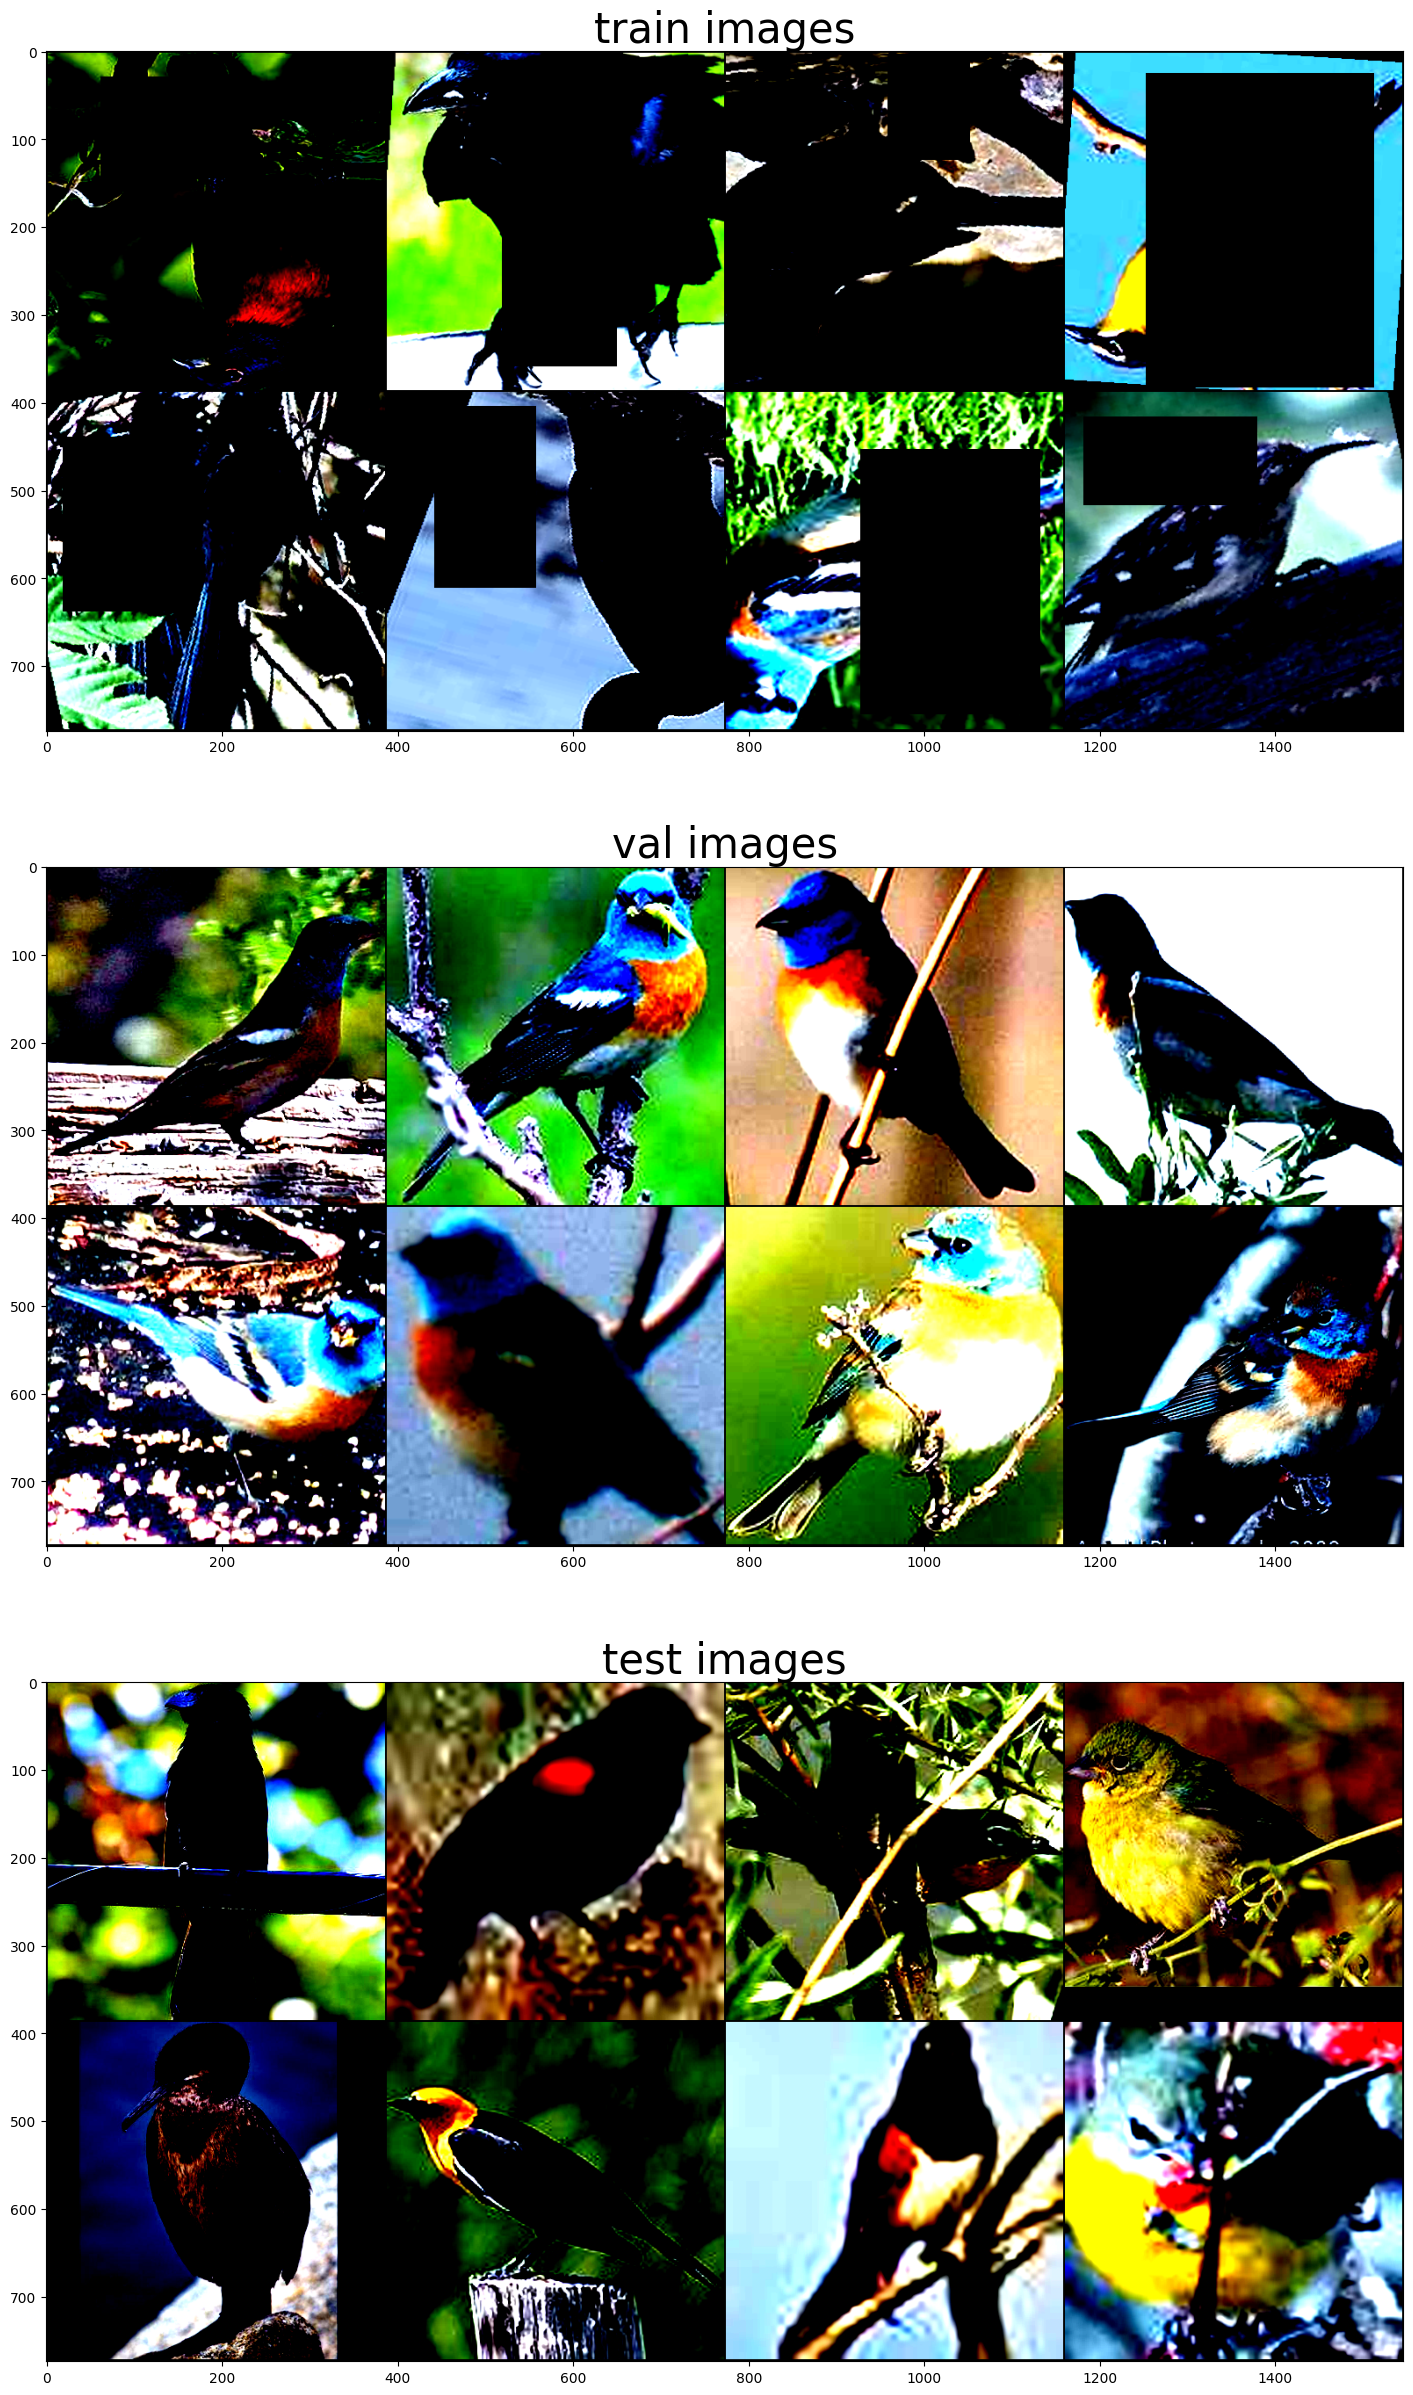

In [51]:
dm = DataModule(
    config,
    path_to_datasets=path_to_datasets / "bird_dataset",
    class_to_idx=class_to_idx,
    train_transforms=data_transforms,
    val_transforms=val_data_transforms,
)

fig, axs = plt.subplots(3, 1, figsize=(20, 30))

for index, (name_loader, loader) in enumerate(
    {
        "train": dm.train_dataloader(),
        "val": dm.val_dataloader(),
        "test": dm.predict_dataloader(),
    }.items()
):
    batch = next(iter(loader))
    out = batch["images"].permute(0, 1, 2, 3)
    out = torchvision.utils.make_grid(out, nrow=4)
    out = np.transpose(out.detach().numpy(), (1, 2, 0))
    axs[index].imshow(out)
    axs[index].set_title(f"{name_loader} images", fontsize=30)


## Instanciate a model

The next part of the process is to create our model. First of all, we define 2 functions that will un/freeze a model recursively. This is usefull for freezing the lowest layers and training only the top fully connected block.

In [47]:
def dfs_freeze(model):
    """Recursively freezes a model"""
    for _, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)


def dfs_unfreeze(model):
    """Recursively unfreezes a model"""
    for _, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = True
        dfs_unfreeze(child)


### Define the model

We then define the model. It is a bit tricky to set the correct logs with `pytorch-lightning`. The interesting part is in the function `self.configure_model()`. This model has the body frozen, expect the fully connected block.

In [17]:
class PreTrainedModel(pl.LightningModule):
    def __init__(self, config: Dict):
        super().__init__()

        self.config = config
        self.config["model_type"] = type(self)

        self.configure_model()
        self.configure_criterion()

    def configure_model(self):
        self.model = pretrained_models.vit_b_16(weights="IMAGENET1K_SWAG_E2E_V1")
        self.model.heads = nn.Identity()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(out_features=self.config["hidden_neurons"]),
            nn.Tanh(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=self.config["hidden_neurons"], out_features=20),
        )
        self.config["model"] = type(self.model)

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch["images"], batch["labels"]
        y_hat = self(x)
        predictions = y_hat.data.max(1, keepdim=True)[1]

        loss = self.criterion(y_hat, y)
        accuracy = torchmetrics.Accuracy().to(self.config["device"])(
            predictions[:, 0], y
        )
        self.log_dict(
            {"train/loss": loss, "train/accuracy": accuracy},
            on_step=True,
            on_epoch=True,
        )
        n_correct_pred = predictions.eq(y.data.view_as(predictions)).sum().detach()
        return {"loss": loss, "n_correct_pred": n_correct_pred, "n_pred": len(y)}

    def training_epoch_end(self, outputs):
        train_acc = sum([x["n_correct_pred"] for x in outputs]) / sum(
            x["n_pred"] for x in outputs
        )
        self.log(
            "train_acc",
            train_acc,
            prog_bar=True,
        )

    def validation_step(self, batch, batch_idx):
        x, y = batch["images"], batch["labels"]
        y_hat = self(x)
        predictions = y_hat.data.max(1, keepdim=True)[1]

        loss = self.criterion(y_hat, y)
        accuracy = torchmetrics.Accuracy().to(self.config["device"])(
            predictions[:, 0], y
        )
        self.log_dict(
            {"val/loss": loss, "val/accuracy": accuracy},
            on_step=True,
            on_epoch=True,
        )
        n_correct_pred = predictions.eq(y.data.view_as(predictions)).sum().detach()
        return {"val_loss": loss, "n_correct_pred": n_correct_pred, "n_pred": len(y)}

    def validation_epoch_end(self, outputs):
        val_acc = sum([x["n_correct_pred"] for x in outputs]) / sum(
            x["n_pred"] for x in outputs
        )
        self.log(
            "val_acc",
            val_acc,
            prog_bar=True,
        )

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = None):
        y_hat = self(batch["images"])
        predictions = y_hat.data.max(1, keepdim=True)[1]
        return predictions

    def configure_criterion(self):
        """Configures the criterion / loss"""
        self.criterion = torch.nn.CrossEntropyLoss(reduction="mean")
        self.config["loss_type"] = type(self.criterion)

    def configure_optimizers(self) -> torch.optim:
        optimizer = torch.optim.AdamW(
            self.fc.parameters(),
            lr=self.config["learning_rate"],
            weight_decay=self.config["weight_decay"],
        )
        self.config["optimizer_type"] = type(optimizer)
        lr_scheduler = CosineAnnealingLR(optimizer, T_max=self.config["T_max"])
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "train/loss",
        }


config["learning_rate"] = 0.0001
config["weight_decay"] = 0.01
config["hidden_neurons"] = 256
config["T_max"] = 200

model = PreTrainedModel(config)
model(next(iter(dm.train_dataloader()))["images"])


Downloading: "https://shi-labs.com/projects/cct/checkpoints/finetuned/cct_14_7x2_384_imagenet.pth" to /root/.cache/torch/hub/checkpoints/cct_14_7x2_384_imagenet.pth


  0%|          | 0.00/85.9M [00:00<?, ?B/s]

https://app.neptune.ai/matiasetcheverry/RECVIS3/e/REC-72
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f812af8bd40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f812af8bd40>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Define the callbacks

We then define the callbacks ie the model checkpoint and the neptune logger. The model with the best validation accuracy are saved in the folder `tmp/`

In [ ]:
model_checkpoint = ModelCheckpoint(
    dirpath="tmp/",
    filename="epoch={epoch}-loss={val/loss_epoch:.3f}-accuracy={val/accuracy_epoch:.3f}",
    auto_insert_metric_name=False,
    monitor="val/accuracy_epoch",
    mode="max",
    verbose=True,
    save_last=False,
    save_top_k=3,
)

logger = None
neptune_logger = False
if neptune_logger:
    neptune_key = "XXX"
    logger = NeptuneLogger(
        project="matiasetcheverry/RECVIS3",
        api_key=neptune_key,
        log_model_checkpoints=False,
    )

    logger.log_model_summary(model=model, max_depth=-1)
    logger.log_hyperparams(params=config)


### Training the model

We then train the model with the body frozen for 6 epochs. 

In [ ]:
trainer = pl.Trainer(
    max_epochs=6,
    callbacks=[model_checkpoint],
    devices="auto",
    accelerator="auto",
    log_every_n_steps=10,
    logger=logger,
)

trainer.fit(
    model,
    datamodule=dm,
)


## Retraining the model

Then, we create a class which will unfreeze the whole model, to train it again. To do so, we select the best current model, unfreeze the whole body, and train it again for 10 epochs.

In [18]:
best_model_path = Path("/kaggle/working/tmp/epoch=39-loss=0.417-accuracy=0.877.ckpt")


class RetrainedModel(PreTrainedModel):
    def __init__(self, config: Dict):
        super().__init__(config)
        self.model = PreTrainedModel.load_from_checkpoint(
            "best_model_path",
            config=config,
            map_location=torch.device(device),
        ).model
        dfs_unfreeze(self.model)

    def configure_optimizers(self) -> torch.optim:
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.config["learning_rate_retrained"],
            weight_decay=self.config["weight_decay"],
        )
        self.config["optimizer_type"] = type(optimizer)
        lr_scheduler = CosineAnnealingLR(
            optimizer, T_max=self.config["T_max_retrained"]
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "train/loss",
        }


config["learning_rate_retrained"] = 1e-5
config["T_max_retrained"] = 200
model = RetrainedModel(config)
model(next(iter(dm.train_dataloader()))["images"])

if neptune_logger:
    logger.log_hyperparams(params=config)

trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[model_checkpoint],
    devices="auto",
    accelerator="auto",
    log_every_n_steps=10,
    logger=logger,
)

trainer.fit(
    model,
    datamodule=dm,
)


https://app.neptune.ai/matiasetcheverry/RECVIS3/e/REC-73
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f812af8bd40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f812af8bd40>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():

AssertionError  File "/opt/conda/lib/python3.7/multiprocessing

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Inference

Once we are satisfied with our model, we simply make predictions on the test dataset. To do so, we load the best model we have.

### Loading the best retrained model

In [42]:
model = RetrainedModel.load_from_checkpoint(
    "/kaggle/working/tmp/retrained-epoch=43-loss=0.321-accuracy=0.919.ckpt",
    config=config,
    map_location=torch.device(device),
)


### Computing predictions

We compute the predictions on the test dataset and save them in a csv file.

In [13]:
predictions = []
paths = []
model.eval().to(device)
with tqdm(dm.val_dataloader(), unit="batch") as vepoch:
    for batch in vepoch:
        images = batch["images"].to(device)
        paths.append(batch["paths"])
        outputs = model(images)
        predictions.extend(outputs.data.max(1, keepdim=True)[1])

predictions = torch.squeeze(torch.concat(predictions, axis=0)).tolist()
paths = [path.stem for minibatch in paths for path in minibatch]
predictions_filename = "/kaggle/working/predictions.csv"
predictions_df = pd.DataFrame([paths, predictions], index=["Id", "Category"]).T
predictions_df.to_csv(predictions_filename, index=False)

if neptune_logger:
    from neptune.new.types import File

    logger.run["predictions"].upload(File.from_path(predictions_filename))



100%|██████████| 38/38 [00:06<00:00,  6.33batch/s]

0.9333333333333333


### Drawing a confusion matrix

We can also plot the confusion matrix. It is normalized by the number of predictions.

<AxesSubplot:>

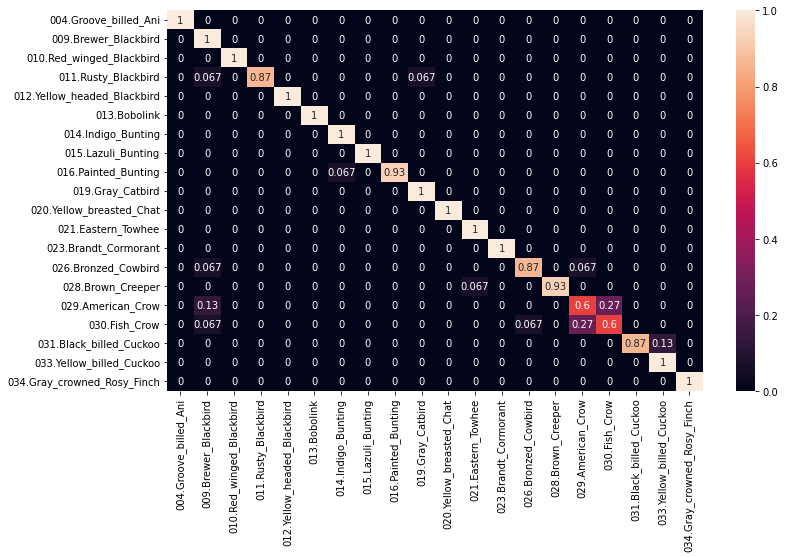

In [14]:
predictions = []
ground_truth = []
paths = []
model.eval().to(device)
with tqdm(dm.val_dataloader(), unit="batch") as vepoch:
    for batch in vepoch:
        images = batch["images"].to(device)
        paths.append(batch["paths"])
        outputs = model(images)
        predictions.extend(outputs.data.max(1, keepdim=True)[1])
        ground_truth.extend(batch["labels"].tolist())

predictions = torch.squeeze(torch.concat(predictions, axis=0)).tolist()
classes = list(class_to_idx.keys())
cf_matrix = confusion_matrix(ground_truth, predictions)
df_cm = pd.DataFrame(
    cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
    index=[i for i in classes],
    columns=[i for i in classes],
)
figure, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.heatmap(df_cm, annot=True, ax=ax)

if neptune_logger:
    logger.run["confusion_matrix"].log(figure)
